## Lets analyze our structre LDOS style

Building our Structure

     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant eps

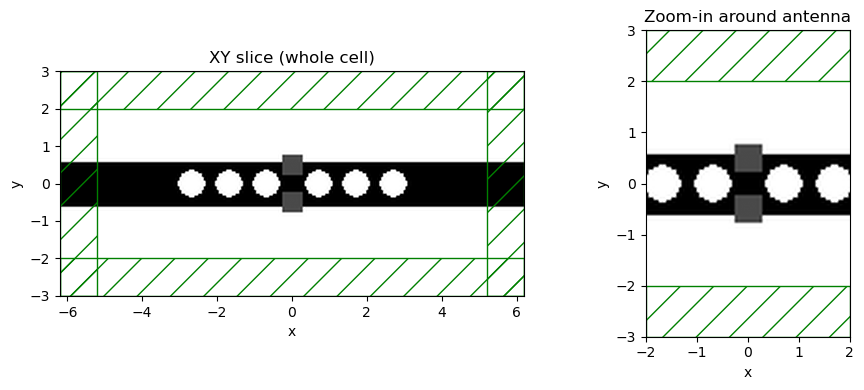

In [352]:
import meep as mp 
import numpy as np

# --- helper function ---
_V3 = getattr(mp, "Vector3", None) or getattr(mp, "Vector3d", None) or getattr(mp, "vec", None)
def V3(x=0, y=0, z=0): 
    return _V3(x, y, z)

# --- geometry params ---
eps = 13.0
w   = 1.2     # waveguide width (along y), adjusted to fit inside sy=4
r   = 0.36    # hole radius
d   = 1.4    # defect spacing
N   = 3      # holes per side
resolution = 20  # pixels/μm

pad  = 2.0
dpml = 1.0
sy   = 6.0    # total height (unchanged)
sx   = 2*(pad + dpml + N) + d - 1
cell = V3(sx, sy, 0)

# --- gold (Drude model) ---
eps_inf = 9.5
omega_p = 7.28
gamma_p = 0.065
gold = mp.Medium(
    epsilon=eps_inf,
    E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_p, gamma=gamma_p)]
)

# --- antenna dimensions ---
gap = 0.5   # gap along y
L   = 0.5   # bar length (along y)
W   = 0.5   # bar width (along x)

# --- geometry builder ---
def build_geometry(gap, N, with_antenna=True):
    g = []
    # dielectric waveguide slab
    g.append(mp.Block(material=mp.Medium(epsilon=eps),
                      center=V3(0,0,0),
                      size=V3(mp.inf, w, mp.inf)))
    # optional holes
    for i in range(N):
        g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(d/2+i*1.0,0)))
        g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(-(d/2+i*1.0),0)))
    # vertical gold dimer antenna
    if with_antenna:
        g.append(mp.Block(material=gold,
                          size=V3(W, L, mp.inf),
                          center=V3(0, +gap/2 + L/2, 0)))
        g.append(mp.Block(material=gold,
                          size=V3(W, L, mp.inf),
                          center=V3(0, -(gap/2 + L/2), 0)))
    return g


# === Geometry visualization ===
import matplotlib.pyplot as plt

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    geometry=build_geometry(gap,N,with_antenna=True),  # toggle
    resolution=resolution,
    dimensions=2,
    symmetries=[mp.Mirror(mp.Y, phase=-1)]
)

plt.figure(figsize=(10,4))

# XY slice full domain
plt.subplot(1,2,1)
sim.plot2D(output_plane=mp.Volume(center=V3(0,0,0),
                                  size=V3(sx, sy, 0)))
plt.title("XY slice (whole cell)")
plt.xlabel("x"); plt.ylabel("y")

# Zoom into antenna region
plt.subplot(1,2,2)
sim.plot2D(output_plane=mp.Volume(center=V3(0,0,0),
                                  size=V3(4, 6, 0)))
plt.title("Zoom-in around antenna")
plt.xlabel("x"); plt.ylabel("y")

plt.tight_layout()
plt.show()


## Conti Sweep

Transmission

Sweeping with gold antenna...
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00362992 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (

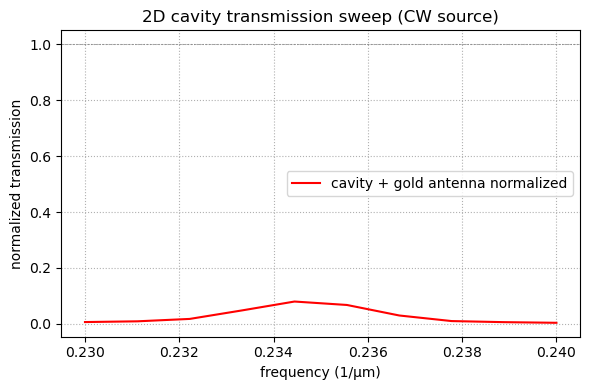

In [237]:
# --- transmission run with CW source at a single frequency ---
def run_transmission_single(geometry, freq):
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=geometry,
        sources=[mp.Source(src=mp.ContinuousSource(frequency=freq),
                           component=mp.Ey,
                           center=V3(-0.5*sx+dpml+0.1, 0),
                           size=V3(0, w, 0))],
        resolution=resolution,
        dimensions=2,
        symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # transmission plane
    trans_x = +0.5*sx - dpml - 0.5
    trans = sim.add_flux(freq, 0, 1,  # single-frequency flux
                         mp.FluxRegion(center=V3(trans_x, 0),
                                       size=V3(0, 2*w, 0)))

    # fixed run time since CW never decays by itself
    sim.run(until=400)  
    return mp.get_fluxes(trans)[0]


# --- sweep over frequency range ---
freqs = np.linspace(0.23, 0.24, 10)   # adjust range/resolution
F_ant, F_ref = [], []

print("Sweeping with gold antenna...")
for f in freqs:
    F_ant.append(run_transmission_single(build_geometry(gap, N, with_antenna=True), f))

print("Sweeping reference (plain slab)...")
for f in freqs:
    F_ref.append(run_transmission_single(build_geometry(gap,0,with_antenna=None), f))

F_ant = np.array(F_ant)
F_ref = np.array(F_ref)

# --- normalized transmission ---
T_ant = F_ant / (F_ref + 1e-30)

# --- plot ---

plt.figure(figsize=(6,4))
#plt.plot(freqs, F_ref, 'g-', label="reference slab")
#plt.plot(freqs, F_ant, 'y-', label="cavity + gold antenna")
plt.plot(freqs, T_ant, 'r-', label="cavity + gold antenna normalized")
plt.axhline(1.0, ls="--", lw=0.5, color="gray")
plt.xlabel("frequency (1/μm)")
plt.ylabel("normalized transmission")
plt.title("2D cavity transmission sweep (CW source)")
plt.legend()
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


LDOS

Sweeping LDOS with just holes...
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00111699 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center 

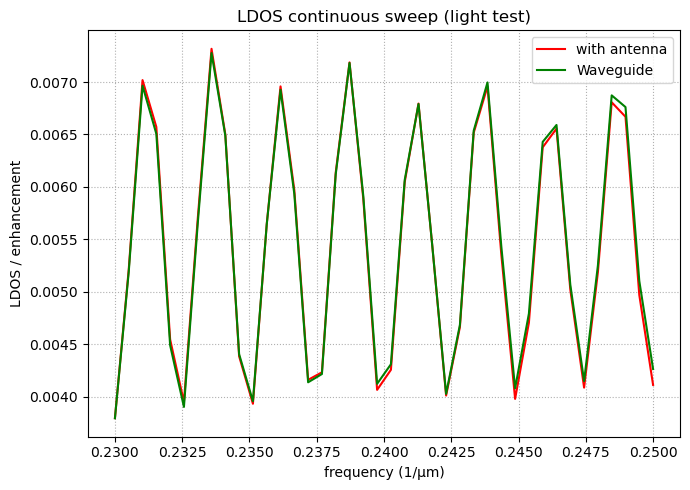

In [239]:
# === LDOS calculation for antenna gap (continuous source sweep) ===
def run_ldos_continuous(N, with_antenna=True, freq=1.0):
    # place dipole source in the antenna gap (y=0, x=0)
    src_pt = V3(0, 0, 0)
    sources = [mp.Source(src=mp.ContinuousSource(frequency=freq),
                         component=mp.Ey,
                         center=src_pt)]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=build_geometry(gap, N, with_antenna=with_antenna),
        sources=sources,
        resolution=10,  # lighter for testing
        dimensions=2,
        symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # run LDOS calculation at this frequency
    sim.run(mp.dft_ldos(freq, 0, 1), until=200)

    return freq, sim.ldos_data[0]


# --- sweep over frequencies ---
freqs = np.linspace(0.23, 0.25, 40)   # frequency sweep range
ldos_ant, ldos_ref, ldos_holes = [], [], []

print("Sweeping LDOS with just holes...")
for f in freqs:
    _, val = run_ldos_continuous(N, with_antenna=None, freq=f)
    ldos_holes.append(val)

print("Sweeping LDOS with antenna...")
for f in freqs:
    _, val = run_ldos_continuous(N, with_antenna=True, freq=f)
    ldos_ant.append(val)

print("Sweeping LDOS plain slab...")
for f in freqs:
    _, val = run_ldos_continuous(0, with_antenna=False, freq=f)
    ldos_ref.append(val)

ldos_holes = np.array(ldos_holes)
ldos_ant = np.array(ldos_ant)
ldos_ref = np.array(ldos_ref)

# --- Purcell enhancement ---
purcellantenna = ldos_ant / (ldos_ref + 1e-30)
purcellholes = ldos_holes / (ldos_ref + 1e-30)

# --- plot ---
plt.figure(figsize=(7,5))
plt.plot(freqs, ldos_ant, 'r-', label="with antenna")
plt.plot(freqs, ldos_holes, 'g-', label="Waveguide")
#plt.plot(freqs, ldos_ref, 'b-', label="slab only")
#plt.plot(freqs, purcell, 'g--', label="Purcell factor")
plt.xlabel("frequency (1/μm)")
plt.ylabel("LDOS / enhancement")
plt.title("LDOS continuous sweep (light test)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


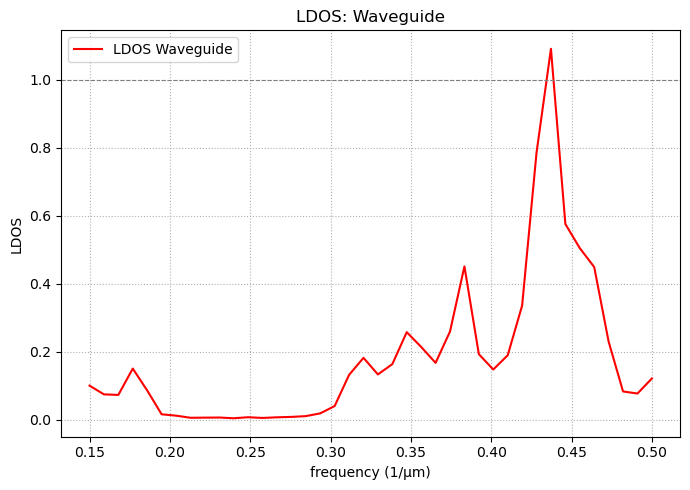

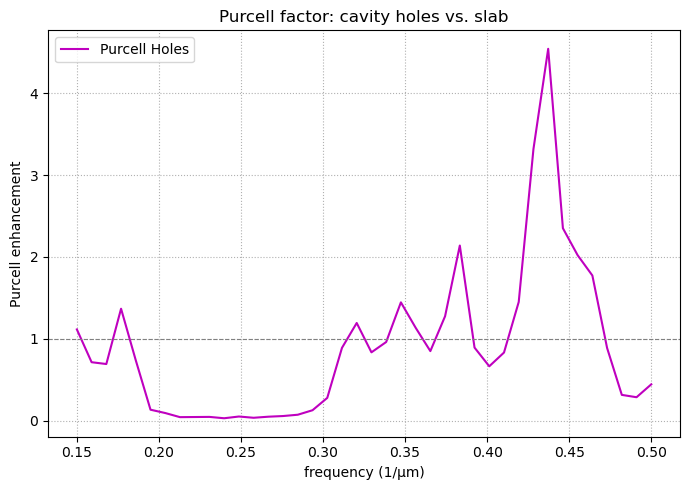

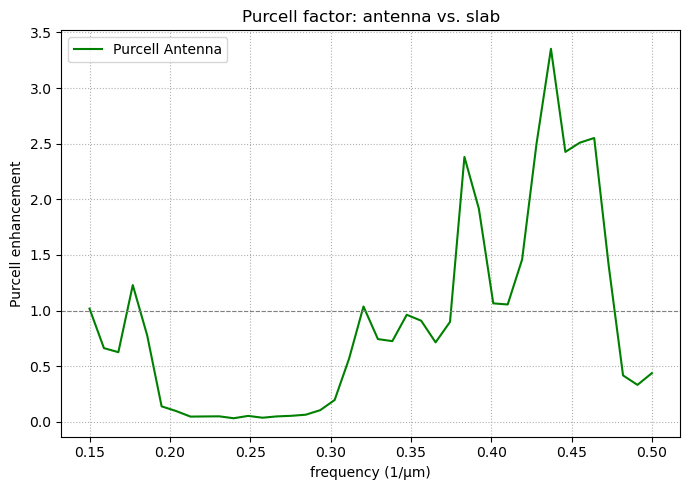

In [169]:
# --- plot Purcell factor (holes vs slab) ---
plt.figure(figsize=(7,5))
plt.plot(freqs, ldos_holes, 'r-', label="LDOS Waveguide")
plt.axhline(1.0, ls="--", color="gray", lw=0.8)
plt.xlabel("frequency (1/μm)")
plt.ylabel("LDOS")
plt.title("LDOS: Waveguide")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- plot Purcell factor (holes vs slab) ---
plt.figure(figsize=(7,5))
plt.plot(freqs, purcellholes, 'm-', label="Purcell Holes")
plt.axhline(1.0, ls="--", color="gray", lw=0.8)
plt.xlabel("frequency (1/μm)")
plt.ylabel("Purcell enhancement")
plt.title("Purcell factor: cavity holes vs. slab")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- plot Purcell factor (antenna vs slab) ---
plt.figure(figsize=(7,5))
plt.plot(freqs, purcellantenna, 'g-', label="Purcell Antenna")
plt.axhline(1.0, ls="--", color="gray", lw=0.8)
plt.xlabel("frequency (1/μm)")
plt.ylabel("Purcell enhancement")
plt.title("Purcell factor: antenna vs. slab")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()



In [170]:
# --- Find max and min Purcell factor ---

# Find the index of the maximum value in the purcell_ant array
idx_max = np.argmax(purcellholes)
# Use that index to find the corresponding frequency
f_max = freqs[idx_max]
# Get the value of the maximum Purcell factor
purcell_max = purcellholes[idx_max]

# Find the index of the minimum value in the purcell_ant array
idx_min = np.argmin(purcellholes)
# Use that index to find the corresponding frequency
f_min = freqs[idx_min]
# Get the value of the minimum Purcell factor
purcell_min = purcellholes[idx_min]

# --- Print the results ---
print(f"Maximum Purcell factor: {purcell_max:.2f} at frequency {f_max:.3f} 1/μm")
print(f"Minimum Purcell factor: {purcell_min:.2f} at frequency {f_min:.3f} 1/μm")

Maximum Purcell factor: 4.54 at frequency 0.437 1/μm
Minimum Purcell factor: 0.03 at frequency 0.240 1/μm


Get a picture of the supported modes, but we only use single frequency for light simulation and fast run time. See Source and DFT monitor

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00296521 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36

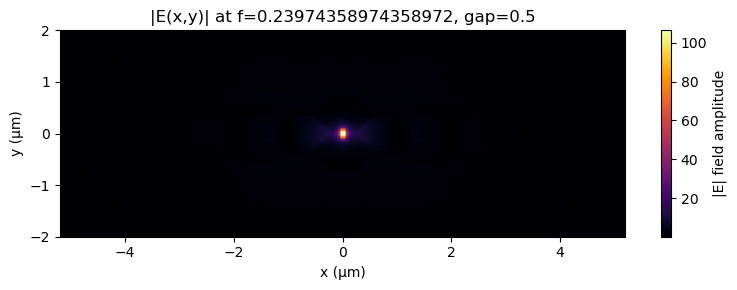

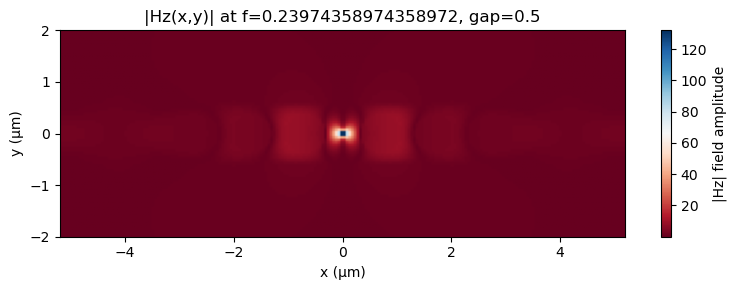

In [194]:
# --- simulation setup ---
freq = f_min
src_pt = mp.Vector3(0,0,0)

cell = mp.Vector3(sx, sy, 0)
dpml = 1.0

sources = [mp.Source(src=mp.ContinuousSource(frequency=freq), amplitude=1.0,
                       component=mp.Ey,
                       center=src_pt,
                       size=mp.Vector3(0, 0, 0))]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    geometry=build_geometry(gap, N, with_antenna=True),
    sources=sources,
    resolution=resolution,
    dimensions=2,
    symmetries=[mp.Mirror(mp.Y, phase=-1)]
)

# --- DFT field monitor over full domain (minus PMLs) ---
field_mon = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hz],
                               freq, 0, 1,
                               where=mp.Volume(center=V3(0,0,0),
                                               size=V3(sx-2*dpml, sy-2*dpml, 0)))

# --- run simulation ---
sim.run(until=200)

# --- extract field data ---
Ex = sim.get_dft_array(field_mon, mp.Ex, 0)
Ey = sim.get_dft_array(field_mon, mp.Ey, 0)
Hz = sim.get_dft_array(field_mon, mp.Hz, 0)

E_amp = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2).T
Hz_amp = np.abs(Hz).T

extent = [-(sx-2*dpml)/2, (sx-2*dpml)/2,
          -(sy-2*dpml)/2, (sy-2*dpml)/2]

# --- plot E-field amplitude ---
plt.figure(figsize=(8,3))
plt.imshow(E_amp, origin='lower', extent=extent, aspect='auto' , cmap="inferno") #fixed colorbar
plt.colorbar(label="|E| field amplitude")
plt.title(f"|E(x,y)| at f={freq}, gap={gap}")
plt.xlabel("x (μm)"); plt.ylabel("y (μm)")
plt.tight_layout()
plt.show()

# --- plot H-field amplitude ---
plt.figure(figsize=(8,3))
plt.imshow(Hz_amp, origin='lower', extent=extent, aspect='auto' , cmap="RdBu")   #fixed colorbar
plt.colorbar(label="|Hz| field amplitude")
plt.title(f"|Hz(x,y)| at f={freq}, gap={gap}")
plt.xlabel("x (μm)"); plt.ylabel("y (μm)")
plt.tight_layout()
plt.show()


-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00291204 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36

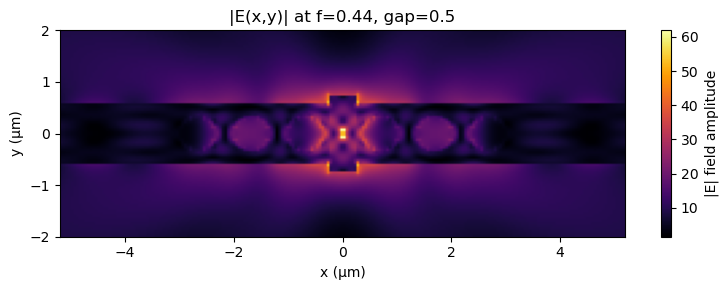

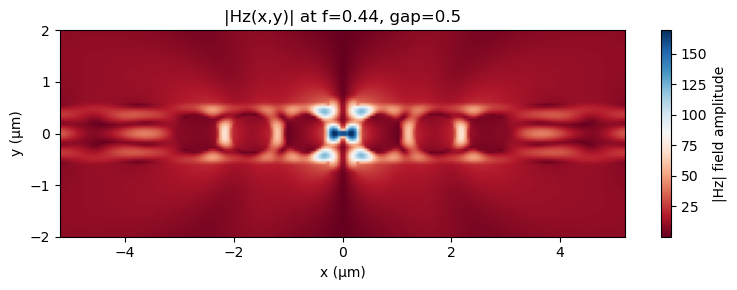

In [195]:
# --- simulation setup ---
freq = f_max
src_pt = mp.Vector3(0,0,0)

cell = mp.Vector3(sx, sy, 0)
dpml = 1.0

sources = [mp.Source(src=mp.ContinuousSource(frequency=freq), amplitude=1.0,
                       component=mp.Ey,
                       center=src_pt,
                       size=mp.Vector3(0, 0, 0))]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    geometry=build_geometry(gap, N, with_antenna=True),
    sources=sources,
    resolution=resolution,
    dimensions=2,
    symmetries=[mp.Mirror(mp.Y, phase=-1)]
)

# --- DFT field monitor over full domain (minus PMLs) ---
field_mon = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hz],
                               freq, 0, 1,
                               where=mp.Volume(center=V3(0,0,0),
                                               size=V3(sx-2*dpml, sy-2*dpml, 0)))

# --- run simulation ---
sim.run(until=200)

# --- extract field data ---
Ex = sim.get_dft_array(field_mon, mp.Ex, 0)
Ey = sim.get_dft_array(field_mon, mp.Ey, 0)
Hz = sim.get_dft_array(field_mon, mp.Hz, 0)

E_amp = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2).T
Hz_amp = np.abs(Hz).T

extent = [-(sx-2*dpml)/2, (sx-2*dpml)/2,
          -(sy-2*dpml)/2, (sy-2*dpml)/2]

# --- plot E-field amplitude ---
plt.figure(figsize=(8,3))
plt.imshow(E_amp, origin='lower', extent=extent, aspect='auto' , cmap="inferno")
plt.colorbar(label="|E| field amplitude")
plt.title(f"|E(x,y)| at f={freq:.2f}, gap={gap}")
plt.xlabel("x (μm)"); plt.ylabel("y (μm)")
plt.tight_layout()
plt.show()

# --- plot H-field amplitude ---
plt.figure(figsize=(8,3))
plt.imshow(Hz_amp, origin='lower', extent=extent, aspect='auto' , cmap="RdBu")
plt.colorbar(label="|Hz| field amplitude")
plt.title(f"|Hz(x,y)| at f={freq:.2f}, gap={gap}")
plt.xlabel("x (μm)"); plt.ylabel("y (μm)")
plt.tight_layout()
plt.show()


Far Field monitor

In [234]:
# === Far-field scan for your cavity (Near2Far done like the tutorial) ===
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# ---- helper ----
_V3 = getattr(mp, "Vector3", None) or getattr(mp, "Vector3d", None) or getattr(mp, "vec", None)
def V3(x=0, y=0, z=0): return _V3(x, y, z)

# ---- geometry params (your values) ----
eps = 13.0
w   = 1.2       # slab/waveguide height (y)
r   = 0.36
d   = 1.4
N   = 3
resolution = 6

pad  = 2.0
dpml = 1.0
sy   = 6.0
sx   = 2*(pad + dpml + N) + d - 1      # your usual sx
cell = V3(sx, sy, 0)

# ---- (optional) gold, unused here ----
eps_inf = 9.5
omega_p = 7.28
gamma_p = 0.065
gold = mp.Medium(epsilon=eps_inf,
                 E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_p, gamma=gamma_p)])

# ---- make the slab finite in x so N2F stays in air ----
# length long enough to include all holes + margin, but not touching PML
hole_span_x = d + 2*(N-1)*1.0           # hole spacing = 1.0 in your code
slab_len_x  = min(sx - 2*(dpml + 0.6),  hole_span_x + 2.0)  # add 1 μm margin each side

def build_geometry(with_holes=True):
    g = []
    # finite-length slab in x
    g.append(mp.Block(material=mp.Medium(epsilon=eps),
                      center=V3(0,0,0),
                      size=V3(slab_len_x, w, mp.inf)))

    if with_holes:
        for i in range(N):
            g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(d/2+i*1.0,0)))
            g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(-(d/2+i*1.0),0)))
    return g

# ---- Near2Far setup (like the tutorial): a closed box in AIR ----
def run_farfield(freq=0.25, with_holes=True, n_angles=181):
    # Source (Gaussian to cover 'freq' well)
    src = [mp.Source(src=mp.GaussianSource(freq, fwidth=0.3*freq),
                     component=mp.Ey,
                     center=V3(0,0,0))]

    sim = mp.Simulation(cell_size=cell,
                        resolution=resolution,
                        sources=src,
                        boundary_layers=[mp.PML(dpml)],
                        geometry=build_geometry(with_holes=with_holes),
                        dimensions=2)  # no symmetries for simplicity

    # Define a rectangular N2F box in air, clear of slab and away from PML
    margin = 0.3
    bx = min(0.5*slab_len_x + 0.5, 0.5*sx - dpml - margin)    # half-width in x
    by = min(0.5*w          + 0.5, 0.5*sy - dpml - margin)    # half-height in y

    # Four sides, bottom/left have weight=-1 (same as tutorial)
    n2f = sim.add_near2far(freq, 0, 1,
            mp.Near2FarRegion(center=V3(0, +by, 0), size=V3(2*bx, 0, 0)),                 # top
            mp.Near2FarRegion(center=V3(0, -by, 0), size=V3(2*bx, 0, 0), weight=-1),      # bottom
            mp.Near2FarRegion(center=V3(+bx, 0, 0), size=V3(0, 2*by, 0)),                 # right
            mp.Near2FarRegion(center=V3(-bx, 0, 0), size=V3(0, 2*by, 0), weight=-1)       # left
        )

    # Run until fields decay (Gaussian), similar to tutorial
    sim.run(until_after_sources=mp.stop_when_dft_decayed())

    # Angular far-field on a circle of radius R
    R = 50.0
    ang = np.linspace(0, 360, n_angles)   # 0..180° for 2D
    I = []
    for a in ang:
        th = np.deg2rad(a)
        pt = mp.Vector3(R*np.cos(th), R*np.sin(th), 0)
        Ex, Ey, Ez, Hx, Hy, Hz = sim.get_farfield(n2f, pt)
        # 2D TEz (Ey source) → intensity proxy from E,H
        I.append(np.abs(Ex)**2 + np.abs(Ey)**2)

    return ang, np.array(I), (bx, by)

# ---- run with & without holes and plot ----
print("Far-field: cavity (with holes)…")
ang_h, I_h, box = run_farfield(freq=0.25, with_holes=True)

print("Far-field: plain slab (reference)…")
ang_r, I_r, _   = run_farfield(freq=0.25, with_holes=False)

I_norm = I_h / (I_r + 1e-30)


Far-field: cavity (with holes)…
-----------
Initializing structure...
time for choose_chunkdivision = 0.00286078 s
Working in 2D dimensions.
Computational cell is 12.3333 x 6 x 0 with resolution 6
     block, center = (0,0,0)
          size (7.4,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+2

run 0 finished at t = 4140.583333333333 (49687 timesteps)
Far-field: plain slab (reference)…
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 2D dimensions.
Computational cell is 12.3333 x 6 x 0 with resolution 6
     block, center = (0,0,0)
          size (7.4,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.00180101 s
-----------
run 0 finished at t = 3323.9166666666665 (39887 timesteps)


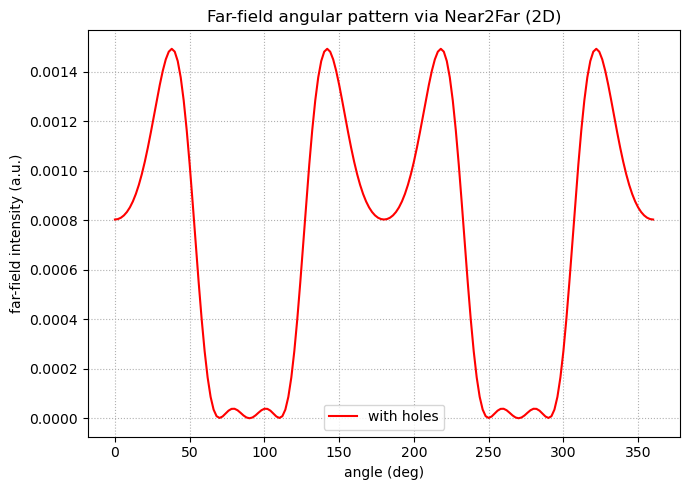

In [235]:
plt.figure(figsize=(7,5))
plt.plot(ang_h, I_h, 'r-', label="with holes")
#plt.plot(ang_r, I_r, 'b--', label="plain slab")
#plt.plot(ang_h, I_norm, 'g-', label="normalized")
plt.xlabel("angle (deg)")
plt.ylabel("far-field intensity (a.u.)")
plt.title("Far-field angular pattern via Near2Far (2D)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

Draw of setup

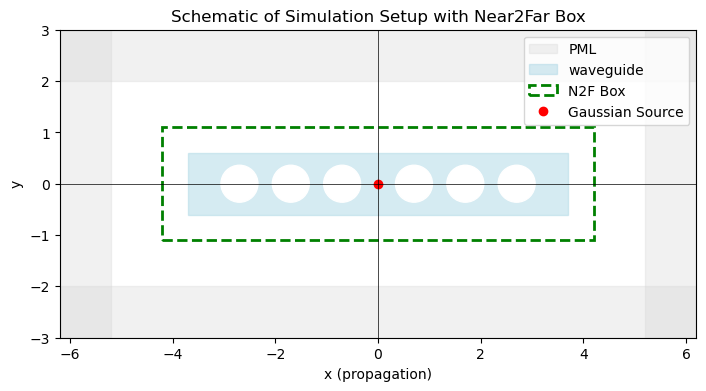

In [233]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- figure ---
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlim(-sx/2, sx/2)
ax.set_ylim(-sy/2, sy/2)
ax.set_aspect("equal")

# Draw PML regions
ax.add_patch(patches.Rectangle((-sx/2, -sy/2), dpml, sy, color="lightgray", alpha=0.3, label="PML"))
ax.add_patch(patches.Rectangle((sx/2-dpml, -sy/2), dpml, sy, color="lightgray", alpha=0.3))
ax.add_patch(patches.Rectangle((-sx/2, -sy/2), sx, dpml, color="lightgray", alpha=0.3))
ax.add_patch(patches.Rectangle((-sx/2, sy/2-dpml), sx, dpml, color="lightgray", alpha=0.3))

# Draw waveguide slab (finite length along x)
ax.add_patch(patches.Rectangle((-slab_len_x/2, -w/2), slab_len_x, w, 
                               color="lightblue", alpha=0.5, label="waveguide"))

# Draw holes
for i in range(N):
    x = d/2 + i*1.0
    ax.add_patch(patches.Circle((x,0), r, color="white"))
    ax.add_patch(patches.Circle((-x,0), r, color="white"))

# === Near2Far monitor box (closed rectangle) ===
margin = 0.3
bx = min(0.5*slab_len_x + 0.5, 0.5*sx - dpml - margin)    # half-width in x
by = min(0.5*w          + 0.5, 0.5*sy - dpml - margin)    # half-height in y
ax.add_patch(patches.Rectangle((-bx, -by), 2*bx, 2*by,
                               fill=False, ls="--", lw=2, edgecolor="green", label="N2F Box"))

# Source (centered Gaussian in your code)
ax.plot([0], [0], 'ro', label="Gaussian Source")

# Decorations
ax.axhline(0, color="k", lw=0.5)
ax.axvline(0, color="k", lw=0.5)
ax.set_title("Schematic of Simulation Setup with Near2Far Box")
ax.set_xlabel("x (propagation)")
ax.set_ylabel("y")
ax.legend(loc="upper right")
plt.show()


## Gaussian Sweep

Transmission

Run cavity + gold antenna…
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000914097 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.

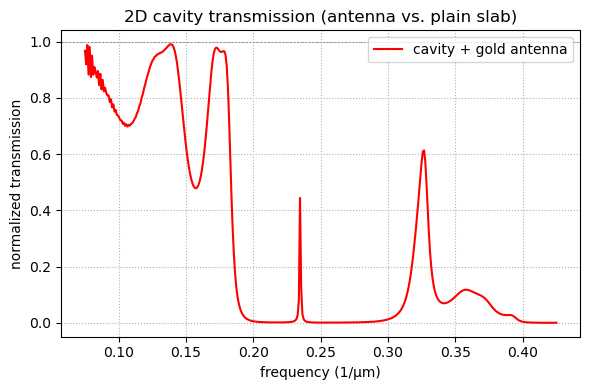

In [173]:
# ---- source/sweep ----
fcen  = 0.25
df    = 0.35
nfreq = 400

# --- transmission run with Gaussian source ---
def run_transmission(geometry):
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=geometry,
        sources=[mp.Source(src=mp.GaussianSource(frequency=fcen, fwidth=df),
                           component=mp.Ey,
                           center=V3(-0.5*sx+dpml+0.1,0),
                           size=V3(0,w,0))],
        resolution=resolution,
        dimensions=2,
        symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # transmission plane
    trans_x = +0.5*sx - dpml - 0.5
    trans = sim.add_flux(fcen, df, nfreq,
                         mp.FluxRegion(center=V3(trans_x,0),
                                       size=V3(0,2*w,0)))
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, V3(trans_x,0), 1e-6))
    return np.array(mp.get_flux_freqs(trans)), np.array(mp.get_fluxes(trans))


# ---- main runs ----
print("Run cavity + gold antenna…")
f_ant, F_ant = run_transmission(build_geometry(gap,N,with_antenna=True))

print("Run reference (plain slab, no holes, no antenna)…")
plain_slab = [mp.Block(material=mp.Medium(epsilon=eps),
                       center=V3(0,0,0),
                       size=V3(mp.inf,w,mp.inf))]

f_ref, F_ref = run_transmission(plain_slab)

# interpolate reference to match antenna run
F_ref = np.interp(f_ant, f_ref, F_ref)

# normalize
T_ant = F_ant / (F_ref + 1e-30)

# ---- plot ----
plt.figure(figsize=(6,4))
plt.plot(f_ant, T_ant, 'r-', label="cavity + gold antenna")
plt.axhline(1.0, ls="--", lw=0.5, color="gray")
plt.xlabel("frequency (1/μm)")
plt.ylabel("normalized transmission")
plt.title("2D cavity transmission (antenna vs. plain slab)")
plt.legend()
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


LDOS

Running LDOS with just holes...
-----------
Initializing structure...
time for choose_chunkdivision = 9.70364e-05 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+

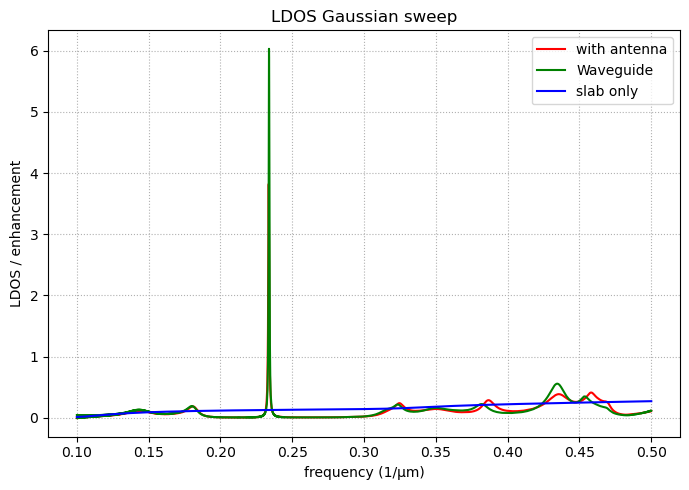

In [353]:
# === LDOS calculation for antenna gap (Gaussian source) ===
def run_ldos_gaussian(N, with_antenna=True):
    # Set up Gaussian source for broad frequency sweep
    fcen = 0.3    # center of the frequency range
    df   = 0.4   # width of the frequency range (0.5 - 0.15)
    nfreq = 5000      # number of frequency points

    # place dipole source in the antenna gap (y=0, x=0)
    src_pt = V3(-0.1, 0, 0)
    sources = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.4),
                         component=mp.Ey,
                         center=src_pt)]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=build_geometry(gap, N, with_antenna=with_antenna),
        sources=sources,
        resolution=10,
        dimensions=2,
        #symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # run with LDOS DFT
    sim.run(
        mp.dft_ldos(fcen, df, nfreq),
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, src_pt, 1e-6
        )
    )

    freqs = np.linspace(fcen - df/2, fcen + df/2, nfreq)
    return freqs, np.array(sim.ldos_data)


# --- run LDOS for 3 cases in a single run per case ---
print("Running LDOS with just holes...")
f_holes, ldos_holes = run_ldos_gaussian(N, with_antenna=None)

print("Running LDOS with antenna...")
f_ant, ldos_ant = run_ldos_gaussian(N, with_antenna=True)

print("Running LDOS plain slab...")
f_ref, ldos_ref = run_ldos_gaussian(0, with_antenna=False)

# --- Purcell enhancement ---
purcellantenna = ldos_ant / (ldos_ref + 1e-30)
purcellholes = ldos_holes / (ldos_ref + 1e-30)

# --- plot ---
plt.figure(figsize=(7,5))
plt.plot(f_ant, ldos_ant, 'r-', label="with antenna")
plt.plot(f_holes, ldos_holes, 'g-', label="Waveguide")
plt.plot(f_ref, ldos_ref, 'b-', label="slab only")
#plt.plot(freqs, purcell, 'g--', label="Purcell factor")
#plt.ylim(0,2)
plt.xlabel("frequency (1/μm)")
plt.ylabel("LDOS / enhancement")
plt.title("LDOS Gaussian sweep")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

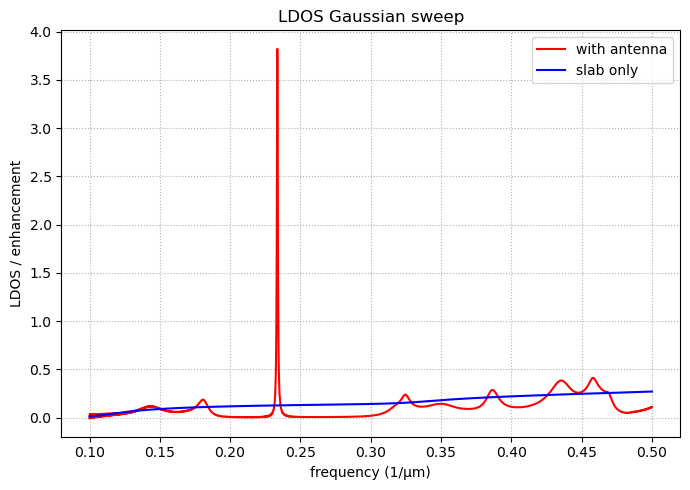

In [320]:
# --- plot ---
plt.figure(figsize=(7,5))
plt.plot(f_ant, ldos_ant, 'r-', label="with antenna")
#plt.plot(f_holes, ldos_holes, 'g-', label="Waveguide")
plt.plot(f_ref, ldos_ref, 'b-', label="slab only")
#plt.plot(freqs, purcell, 'g--', label="Purcell factor")
#plt.ylim(0,2)
plt.xlabel("frequency (1/μm)")
plt.ylabel("LDOS / enhancement")
plt.title("LDOS Gaussian sweep")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

Now we are looking again at the Transmission spectrum and monitor E/H

Run cavity + gold antenna…
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0688479 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,

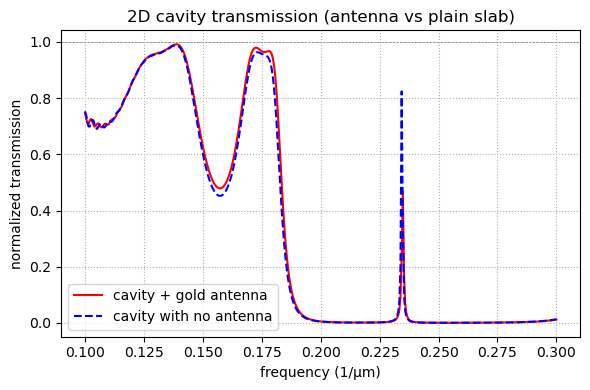

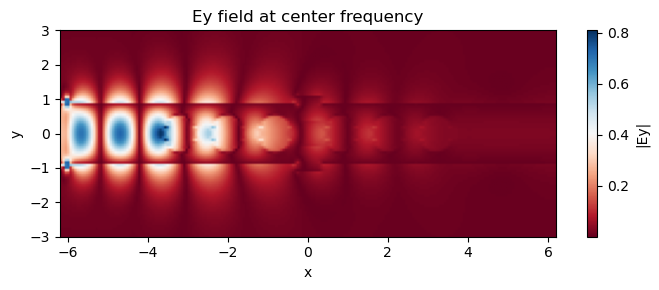

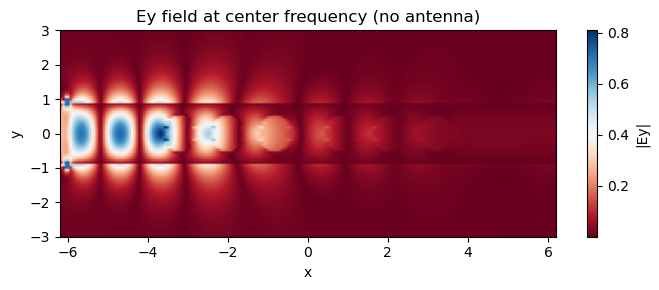

In [347]:
# === Transmission + E/H field monitoring ===
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# --- helper ---
_V3 = getattr(mp, "Vector3", None) or getattr(mp, "Vector3d", None) or getattr(mp, "vec", None)
def V3(x=0, y=0, z=0): 
    return _V3(x, y, z)

# --- geometry params ---
eps = 13.0
w   = 1.2     # waveguide width
r   = 0.36    # hole radius
d   = 1.4     # defect spacing
N   = 3       # holes per side
resolution = 20

pad  = 2.0
dpml = 1.0
sy   = 6.0
sx   = 2*(pad + dpml + N) + d - 1
cell = V3(sx, sy, 0)

# --- gold (Drude model) ---
eps_inf = 9.5
omega_p = 7.28
gamma_p = 0.065
gold = mp.Medium(
    epsilon=eps_inf,
    E_susceptibilities=[mp.DrudeSusceptibility(frequency=omega_p, gamma=gamma_p)]
)

# --- antenna dimensions ---
gap = 0.5
L   = 0.5
W   = 0.5

# --- geometry builder ---
def build_geometry(gap, N, with_antenna=True):
    g = []
    # dielectric waveguide slab
    g.append(mp.Block(material=mp.Medium(epsilon=eps),
                      center=V3(0,0,0),
                      size=V3(mp.inf, w, mp.inf)))
    # holes
    for i in range(N):
        g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(d/2+i*1.0,0)))
        g.append(mp.Cylinder(radius=r, height=mp.inf, material=mp.air, center=V3(-(d/2+i*1.0),0)))
    # antenna
    if with_antenna:
        g.append(mp.Block(material=gold,
                          size=V3(W, L, mp.inf),
                          center=V3(0, +gap/2 + L/2, 0)))
        g.append(mp.Block(material=gold,
                          size=V3(W, L, mp.inf),
                          center=V3(0, -(gap/2 + L/2), 0)))
    return g


# --- source/sweep ---
fcen  = 0.2
df    = 0.2
nfreq = 400

# --- transmission run ---
def run_transmission(geometry):
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=geometry,
        sources=[mp.Source(src=mp.GaussianSource(frequency=fcen, fwidth=df),
                           component=mp.Ey,
                           center=V3(-0.5*sx+dpml+0.1,0),
                           size=V3(0,w,0))],
        resolution=resolution,
        dimensions=2,
        symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # transmission plane
    trans_x = +0.5*sx - dpml - 0.5
    trans = sim.add_flux(fcen, df, nfreq,
                         mp.FluxRegion(center=V3(trans_x,0),
                                       size=V3(0,2*w,0)))

    # --- add E/H field monitor ---
    field_mon = sim.add_dft_fields([mp.Ey, mp.Hz], fcen, df, nfreq,
                                   where=mp.Volume(center=V3(0,0,0),
                                                   size=V3(sx-2*dpml, sy-2*dpml, 0)))

    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, V3(trans_x,0), 1e-6))

    # extract spectra
    freqs = np.array(mp.get_flux_freqs(trans))
    fluxes = np.array(mp.get_fluxes(trans))

    # extract fields (just an example at central frequency index)
    Ey_map = sim.get_dft_array(field_mon, mp.Ey, nfreq//2)
    Hz_map = sim.get_dft_array(field_mon, mp.Hz, nfreq//2)

    return freqs, fluxes, Ey_map, Hz_map


# --- runs ---
print("Run cavity + gold antenna…")
f_ant, F_ant, Ey_ant, Hz_ant = run_transmission(build_geometry(gap,N,with_antenna=True))

print("Run reference (plain slab, no holes, no antenna)…")
plain_slab = [mp.Block(material=mp.Medium(epsilon=eps),
                       center=V3(0,0,0),
                       size=V3(mp.inf,w,mp.inf))]
f_ref, F_ref, _, _ = run_transmission(plain_slab)

print("Run cavity with no antenna...")
f_no_ant, F_no_ant, Ey_no_ant, Hz_no_ant = run_transmission(build_geometry(gap, N, with_antenna=False))

# normalize
F_ref = np.interp(f_ant, f_ref, F_ref)
T_ant = F_ant / (F_ref + 1e-30)
T_no_ant = F_no_ant / (F_ref + 1e-30)

# --- plot transmission ---
plt.figure(figsize=(6,4))
plt.plot(f_ant, T_ant, 'r-', label="cavity + gold antenna")
plt.plot(f_no_ant, T_no_ant, 'b--', label="cavity with no antenna")
plt.axhline(1.0, ls="--", lw=0.5, color="gray")
plt.xlabel("frequency (1/μm)")
plt.ylabel("normalized transmission")
plt.title("2D cavity transmission (antenna vs plain slab)")
plt.legend()
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

# --- plot E-field map (example at fcen) ---
plt.figure(figsize=(7,3))
plt.imshow(np.abs(Ey_ant).T, origin='lower',
           extent=[-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy],
           aspect='auto', cmap="RdBu")
plt.colorbar(label="|Ey|")
plt.title("Ey field at center frequency")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

# --- plot E-field map (no antenna) ---
plt.figure(figsize=(7,3))
plt.imshow(np.abs(Ey_no_ant).T, origin='lower',
           extent=[-0.5*sx, 0.5*sx, -0.5*sy, 0.5*sy],
           aspect='auto', cmap="RdBu")
plt.colorbar(label="|Ey|")
plt.title("Ey field at center frequency (no antenna)")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

We do a single freq sweep and show how the system reacts

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000936031 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.3

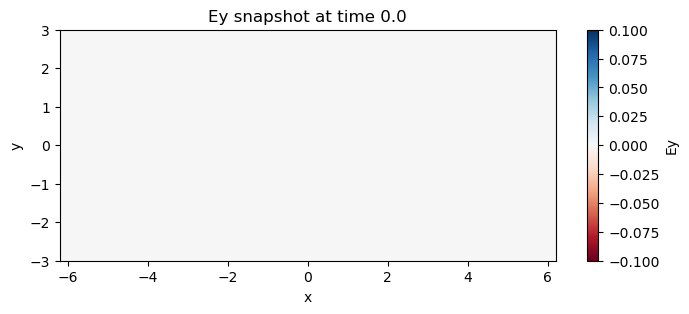

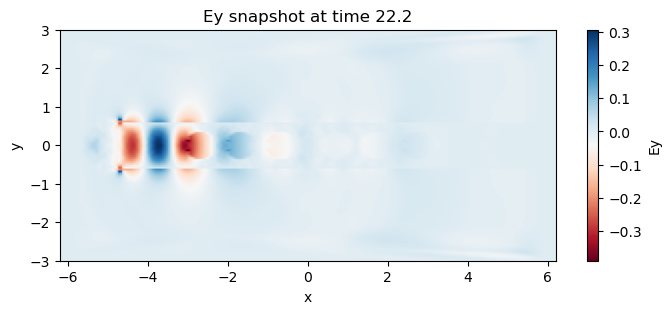

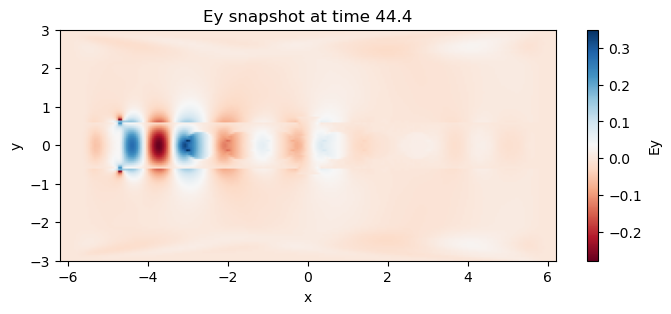

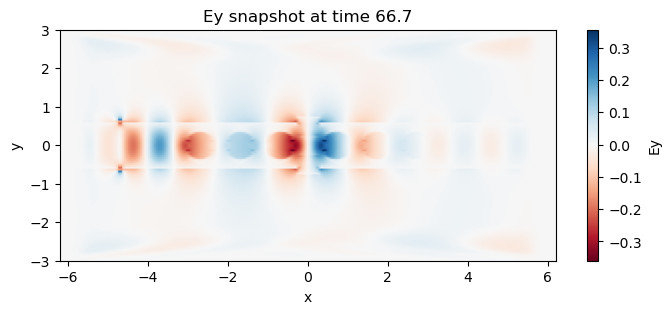

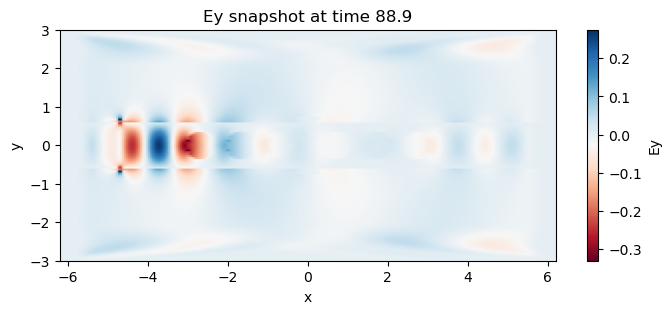

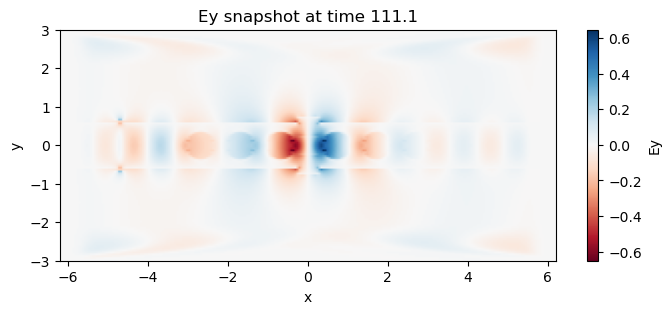

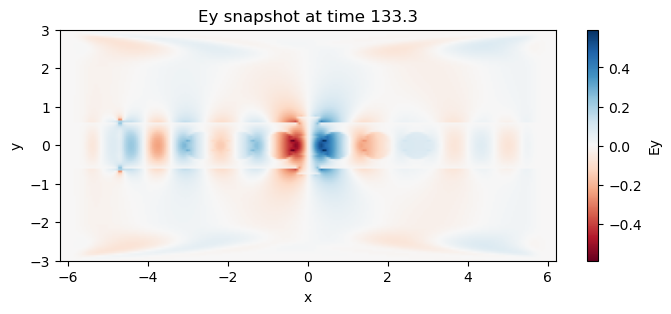

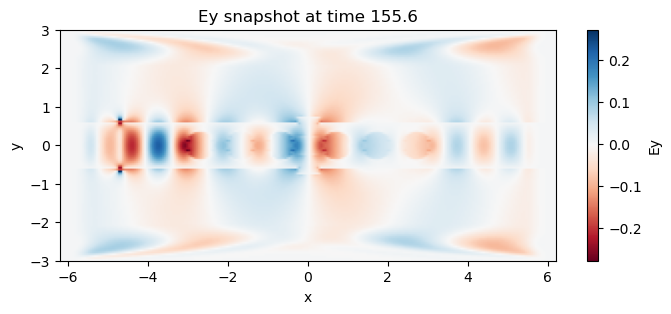

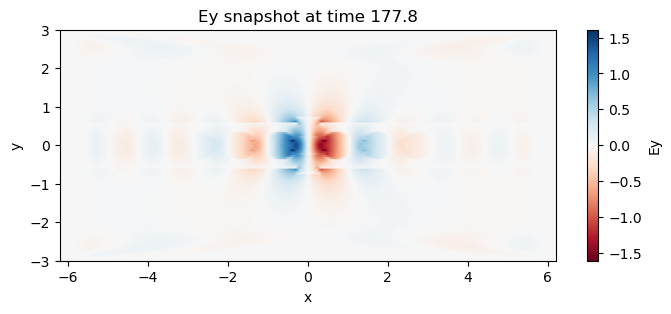

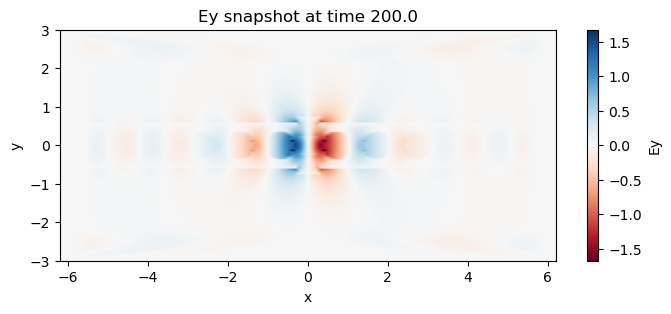

In [346]:
# === Time-domain field snapshots (manual stepping, works without mp.at_times) ===
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

def run_time_snapshots(geometry, freq=0.25, nsteps=20, until=200):
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        geometry=geometry,
        sources=[mp.Source(src=mp.ContinuousSource(frequency=freq),
                           component=mp.Ey,
                           center=V3(-0.5*sx+dpml+0.5,0),
                           size=V3(0,w,0))],
        resolution=resolution,
        dimensions=2,
        symmetries=[mp.Mirror(mp.Y, phase=-1)]
    )

    # times for snapshots
    times = np.linspace(0, until, nsteps)
    fields = []

    for t in times:
        sim.run(until=t)  # advance simulation until time t
        Ey = sim.get_array(center=V3(), size=cell, component=mp.Ey)
        Hz = sim.get_array(center=V3(), size=cell, component=mp.Hz)
        fields.append((t, Ey.copy(), Hz.copy()))

    return fields

# --- run with antenna ---
snapshots = run_time_snapshots(build_geometry(gap, N, with_antenna=True), freq=0.235, nsteps=10, until=200)

# --- plot a few snapshots ---
for i, (t, Ey, Hz) in enumerate(snapshots):
    plt.figure(figsize=(8,3))
    plt.imshow(Ey.T, cmap="RdBu", origin="lower",
               extent=[-sx/2, sx/2, -sy/2, sy/2], aspect="auto")
    plt.colorbar(label="Ey")
    plt.title(f"Ey snapshot at time {t:.1f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()
